In [214]:
import shapefile
import geopandas as gpd
import os
import numpy as np
import matplotlib.pyplot as plt
import datetime
import pandas as pd
import rasterio as rio
from rasterio.features import rasterize
import xarray as xr
import rioxarray as rxr
import requests
from skimage.measure import block_reduce

In [2]:
FIRE_PERIM_DIR="../../Fire_Perim/"
FIRE_EVENT="fired_conus-ak_events_nov2001-march2021.gpkg"
FIRE_DAY="fired_conus-ak_daily_nov2001-march2021.gpkg"

In [3]:
fire_event_df=gpd.read_file(os.path.join(FIRE_PERIM_DIR,FIRE_EVENT))

In [4]:
fire_day_df=gpd.read_file(os.path.join(FIRE_PERIM_DIR,FIRE_DAY))

In [13]:
#fire_event_df_rpj=fire_event_df.to_crs("EPSG:4326")

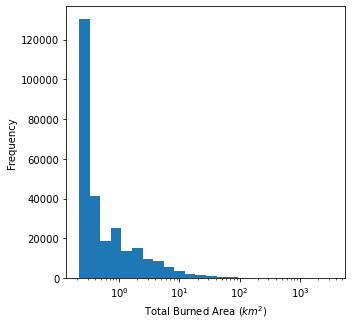

In [14]:
plt.figure(figsize=(5,5))
plt.hist(fire_event_df.area/1e6, bins=np.logspace(start=np.log10(fire_event_df.area.min()/1e6), stop=np.log10(fire_event_df.area.max()/1e6), num=25))
plt.gca().set_xscale("log")
plt.xlabel("Total Burned Area ($km^2$)")
plt.ylabel("Frequency")
plt.show()

#### Plot the longest burning fire in the dataset

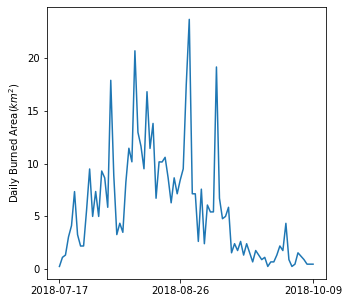

In [15]:
plt.figure(figsize=(5,5))
longest_event_index=fire_event_df.iloc[fire_event_df.event_dur.argmax()]["id"]
longest_fire=fire_day_df[fire_day_df["id"]==387281]
date_range=pd.to_datetime(longest_fire.date, infer_datetime_format=True)
plt.plot(date_range, longest_fire.area/1e6)
plt.ylabel("Daily Burned Area($km^2$)")
plt.xticks([date_range.iloc[0],date_range.iloc[40], date_range.iloc[80]])
plt.show()

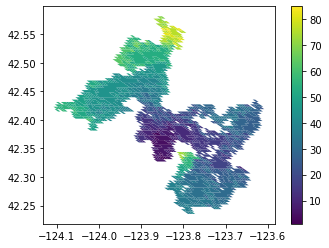

In [16]:
longest_fire.to_crs("EPSG:4326").plot("event_day", legend=True)
plt.show()

### Rasterize Fire Geometries for input into CNN

In [5]:
medium_fire_event=fire_event_df[(fire_event_df.area >= 10e6) & (fire_event_df.area <= 30e6) & (fire_event_df.event_dur > 3)]
medium_event_bounds=medium_fire_event.bounds
medium_event_bounds["width"]=((medium_event_bounds["maxx"]-medium_event_bounds["minx"])/463.3127165283333).astype(int)
medium_event_bounds["height"]=((medium_event_bounds["maxy"]-medium_event_bounds["miny"])/463.3127165283333).astype(int)

def return_transform_object(west, south, east, north, width, height):
    return rio.transform.from_bounds(west, south, east, north, width, height)

medium_event_bounds["transform"]=medium_event_bounds.apply(lambda x: return_transform_object(x["minx"], x["miny"], x["maxx"], x["maxy"], x["width"], x["height"]), axis=1)
medium_fire_event=medium_fire_event.join(medium_event_bounds)

medium_fire_day=fire_day_df[[True if a in medium_fire_event["id"].values else False for a in fire_day_df["id"] ]]

medium_fire_day["event_id"]=medium_fire_day["id"].values
medium_fire_event["event_id"]=medium_fire_event["id"].values

medium_fire_event["date"]=pd.to_datetime(medium_fire_event["ig_date"])
medium_fire_event["envelope_centroid"]=medium_fire_event.envelope.centroid.to_crs("EPSG:4326")

medium_fire=medium_fire_day.merge(medium_fire_event[["event_id", "minx", "miny", "maxx", "maxy", "width", "height", "transform"]], on="event_id")

medium_fire=medium_fire[(medium_fire.width < 32) & (medium_fire.height < 32)]

/opt/anaconda3/envs/FireML/lib/python3.8/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [6]:
def return_raster(geom, height, width, trans):
    return rasterize([geom,], out_shape=(height, width), transform=trans)
medium_fire["raster"]=medium_fire.apply(lambda x: return_raster(x["geometry"], x["height"], x["width"], x["transform"]), axis=1)

def padding(org, dim=32):
    h=org.shape[0]
    w=org.shape[1]
    h_dif=dim-h
    w_dif=dim-w
    left_pad=w_dif//2
    right_pad=w_dif-left_pad
    top_pad=h_dif//2
    bottom_pad=h_dif-top_pad
    return np.pad(org, ((top_pad, bottom_pad), (left_pad, right_pad)), 'constant', constant_values=0)

medium_fire["padded_raster"]=medium_fire["raster"].apply(padding)

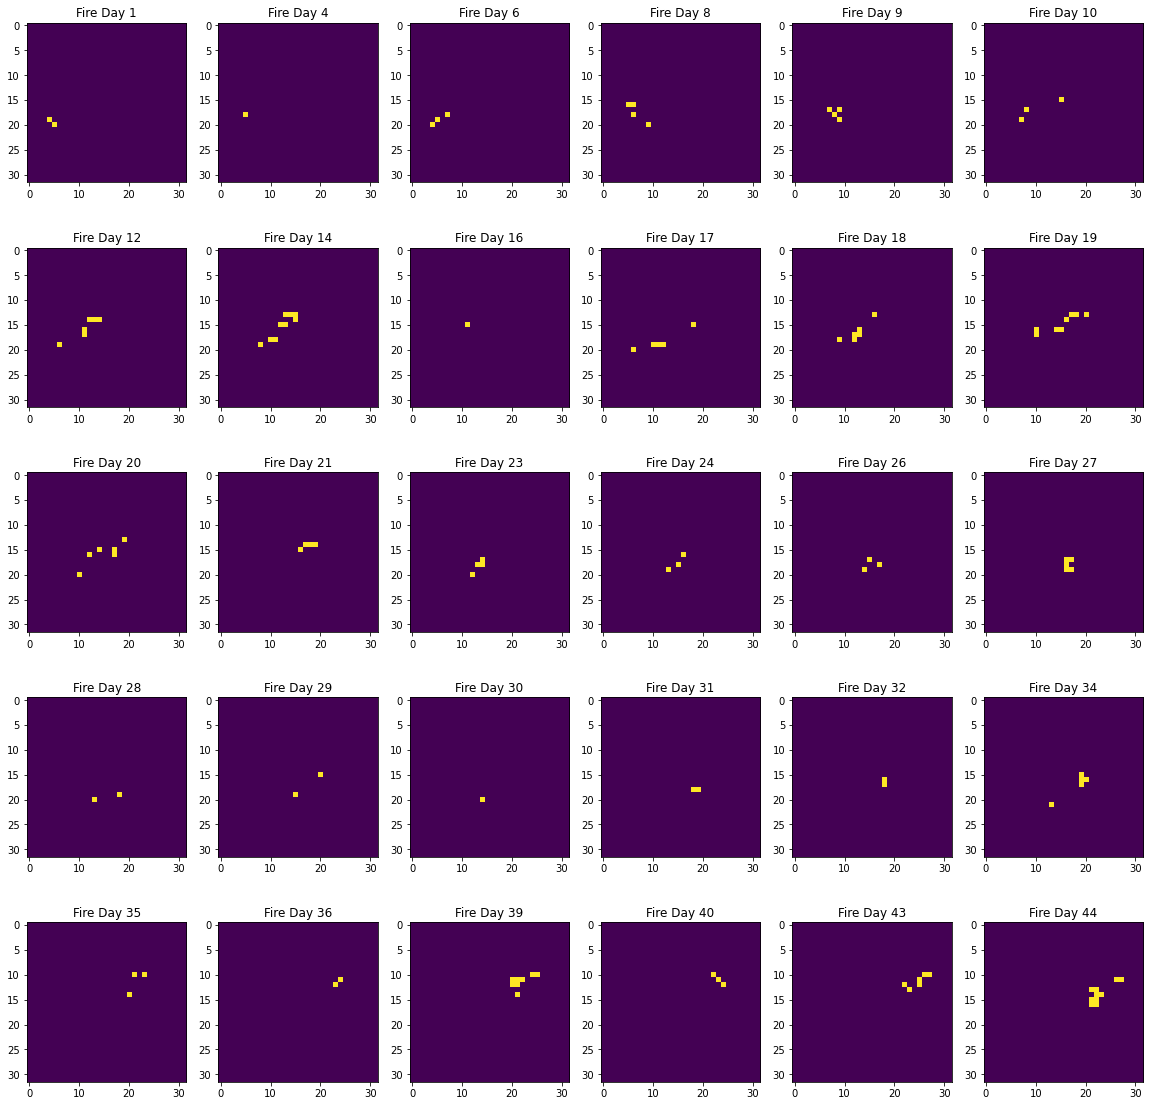

In [7]:
fig, axs=plt.subplots(5,6, figsize=(20,20))
ax=axs.flatten()
longest_fire=medium_fire[medium_fire.event_id==154860]
for i in range(30):
    ax[i].imshow(longest_fire["padded_raster"].iloc[i])
    ax[i].set_title("Fire Day {}".format(longest_fire["event_day"].iloc[i]))

### Use Global MODIS subset tool to retrieve NDVI

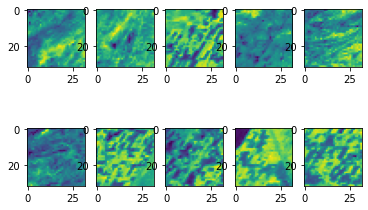

In [281]:
fig, axs=plt.subplots(2,5)
ax=axs.flatten()
for i in range(10):
    env_cen_x=medium_fire_event["centroid_points"].iloc[i].__geo_interface__["coordinates"][0]
    env_cen_y=medium_fire_event["centroid_points"].iloc[i].__geo_interface__["coordinates"][1]

    BASE_URL="https://modis.ornl.gov/rst/api/v1"
    MODIS_VI_SUBSET="/MOD13Q1/subset"
    MODIS_VI_DATES="/MOD13Q1/dates"
    date_r=requests.get(BASE_URL+MODIS_VI_DATES, params={"longitude": env_cen_x, "latitude": env_cen_y})

    res=pd.DataFrame(date_r.json()["dates"])
    res["date"]=pd.to_datetime(res["calendar_date"])

    date_idx=abs(res["date"]-medium_fire_event.iloc[i]["date"]).idxmin()

    while (res["date"][date_idx]+ np.timedelta64(16, "D")>=medium_fire_event.iloc[i]["date"]):
        date_idx=date_idx-1

    modis_date=res["modis_date"][date_idx]

    data_r=requests.get(BASE_URL+MODIS_VI_SUBSET, params={"longitude": env_cen_x,
                                                          "latitude": env_cen_y,
                                                          "startDate": modis_date,
                                                          "endDate": modis_date,
                                                          "kmAboveBelow":10,
                                                          "kmLeftRight":10,"band":["250m_16_days_NDVI",]})

    ndvi_data=np.array(data_r.json()["subset"][0]["data"]).reshape(81,81)

    xleft=float(data_r.json()["xllcorner"])
    ybot=float(data_r.json()["yllcorner"])
    cs=data_r.json()["cellsize"]

    ytop=ybot+ 81 * cs
    xright=xleft+81*cs

    t=rio.transform.from_bounds(xleft, ybot, xright, ytop, 81, 81)

    b=medium_fire_event.iloc[i].geometry.envelope.bounds

    bounds=rio.transform.rowcol(t, b[0], b[3]), rio.transform.rowcol(t, b[2], b[1])

    h=int((bounds[1][0]-(bounds[0][0]+1))/2)
    w=int((bounds[1][1]- (bounds[0][1]+1))/2)

    dim=32

    h_dif=dim-h
    w_dif=dim-w
    left_pad=w_dif//2
    right_pad=w_dif-left_pad
    top_pad=h_dif//2
    bottom_pad=h_dif-top_pad

    ndvi_data_s=ndvi_data[bounds[0][0]+1-2*top_pad: bounds[1][0]+2*bottom_pad, bounds[0][1]+1-2*left_pad:bounds[1][1]+2*right_pad]

    ndvi_data_reduced=block_reduce(ndvi_data_s, (2,2), np.mean)/1e4

    ax[i].imshow(ndvi_data_reduced)
